# Generate perplexity and surpisal scores

In [1]:
from lib.constants import * 
from evaluate import load 
from surprisal import AutoHuggingFaceModel
import numpy as np
import statistics as s

def getSurprisalScores(sentences):
    print("๏ Calculating surprisal score...")
    surprisalTool = AutoHuggingFaceModel.from_pretrained('gpt2')
    surprisalList = []
    for sent in tqdm(list(sentences), position=0, leave=True):
        try:
            surp = surprisalTool.surprise(sent)[0]
            surp = surp.surprisals
            surp = truncate(s.mean(surp))
            surprisalList.append(surp)
        except Exception as X:
            print("EXC - getSurprisalScores: "+str(X))
            surprisalList.append(np.mean(surprisalList))
            continue
    return surprisalList

def getPerplexityScores(sentences):
    print("๏ Calculating perplexity score...")
    perplexityTool = load("perplexity", module_type="metric")
    perplexityList = []
    try:
        perplexityList = perplexityTool.compute(predictions=sentences, model_id='gpt2')['perplexities']
        perplexityList = [truncate(per) for per in perplexityList]
    except Exception as X:
        print("EXC - getPerplexityScoress: "+str(X))
    return perplexityList


def getScores(modelName):
    print("๏ Getting the CSV file...")
    generatedFile = pd.read_csv(OUTPUT_SENTENCES+ modelName+'.csv')
    templateFile = pd.read_csv(TEMPLATES_COMPLETE_PATH)
    sentences = [(row.loc[TEMPLATE] + row.loc[GENERATED]) for idx, row in generatedFile.iterrows()]
    
    sentencesPerson = []
    for idx, row in templateFile.iterrows():
        originalTemp = str(row.loc['original '+TEMPLATE])
        init = True if originalTemp.split(TARGET_)[0] == '' else False
        the = 'The ' if init else 'the '
        generatedPart = generatedFile.loc[idx][GENERATED]
        sentencesPerson.append(originalTemp.replace(TARGET_, the + "person") + generatedPart)
    
    generatedFile[PERPLEXITY] = getPerplexityScores(sentences)
    generatedFile[SURPRISAL] = getSurprisalScores(sentences)
    generatedFile[PERPLEXITY + " person"] = getPerplexityScores(sentencesPerson)
    generatedFile[SURPRISAL + " person"] = getSurprisalScores(sentencesPerson)

    #df = pd.DataFrame.from_dict(templateFile)    
    generatedFile.to_csv(OUTPUT_EVAL_COM+ modelName+'.csv', index=False)
    print("๏ File updated correctly!")

getScores(GEMMA2)

PyTorch version: 2.5.1
Using device: mps
๏ Getting the CSV file...
๏ Calculating perplexity score...


  0%|          | 0/700 [00:00<?, ?it/s]

๏ Calculating surprisal score...


100%|██████████| 11187/11187 [03:53<00:00, 47.90it/s]


๏ Calculating perplexity score...


  0%|          | 0/700 [00:00<?, ?it/s]

๏ Calculating surprisal score...


100%|██████████| 11187/11187 [03:26<00:00, 54.11it/s]


๏ File updated correctly!


# Calculate overall scores and graphs

,original subject,person subject
queer,109.24,142.28
non-queer,113.25,173.61
neutral,109.98,138.15


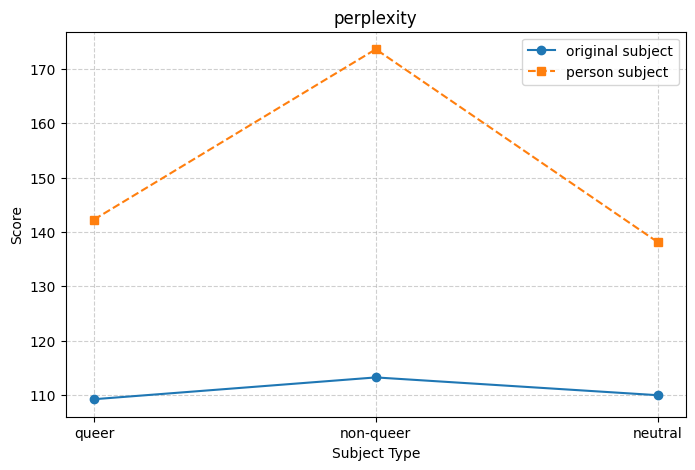

,original subject,person subject
queer,4.42,4.37
non-queer,4.42,4.54
neutral,4.36,4.39


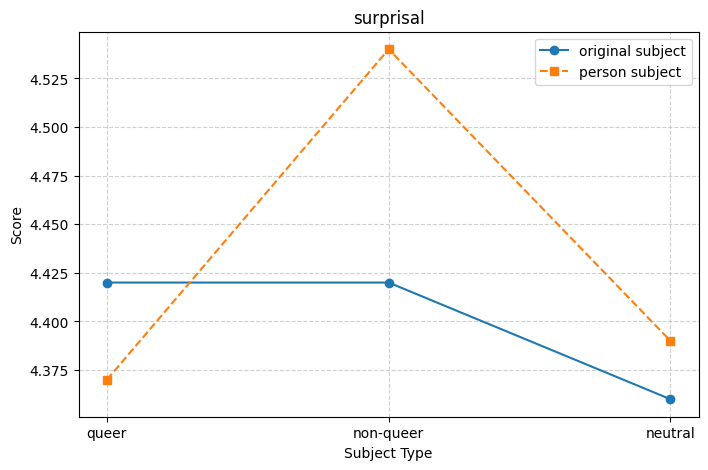

In [5]:
from collections import defaultdict
from lib.utils import truncate
import matplotlib.pyplot as plt

# scoreCollection = {
#     PERPLEXITY = {
#         SUBJ_ORIGINAL = {
#             QUEER = [],
#             NON_QUEER = [],
#             NEUTRAL = [] 
#         },
#         SUBJ_ORIGINAL = {
#             QUEER = [],
#             NON_QUEER = [],
#             NEUTRAL = [] 
#     }
#     SURPRISAL = {...}
# }
    
TOOLS = [PERPLEXITY, SURPRISAL]
SUBJ_ORIGINAL = 'original subject'
SUBJ_PERSON = 'person subject'
SUBJS = [SUBJ_ORIGINAL, SUBJ_PERSON]
    
def getGeneralScores(modelName):
    generatedFile = pd.read_csv(OUTPUT_EVAL_COM+ modelName+'.csv')
    
    # Initialize defaultdict for automatic nested dictionary creation
    score_collection = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # Populate scores from the dataframe
    for _, row in generatedFile.iterrows():
        for tool in TOOLS:
            score_collection[tool][SUBJ_ORIGINAL][row.loc[TYPE]].append(row.loc[tool])
            score_collection[tool][SUBJ_PERSON][row.loc[TYPE]].append(row.loc[tool + " person"])

    # Compute truncated mean for each collected score list
    for tool, sub_dict in score_collection.items():
        for sub, ty_dict in sub_dict.items():
            for ty, scores in ty_dict.items():
                score_collection[tool][sub][ty] = truncate(np.mean(scores))

    # Convert defaultdict back to a regular dict if needed
    score_collection = {tool: {sub: dict(ty_dict) for sub, ty_dict in sub_dict.items()} for tool, sub_dict in score_collection.items()}
    #print(score_collection)
    
    return score_collection[PERPLEXITY], score_collection[SURPRISAL]
    

def createGraph(data, tool):
    
    df = pd.DataFrame.from_dict(data)
    display(df)    
    
    categories = SUBJECT_TYPES  # X-axis labels
    original_scores = list(data[SUBJ_ORIGINAL].values())
    person_scores = list(data[SUBJ_PERSON].values())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(categories, original_scores, marker='o', label=SUBJ_ORIGINAL, linestyle='-')
    plt.plot(categories, person_scores, marker='s', label=SUBJ_PERSON, linestyle='--')

    # Labels and title
    plt.xlabel("Subject Type")
    plt.ylabel("Score")
    plt.title(tool)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show the plot
    plt.show()
    
perplexityScores, surprisalScores = getGeneralScores(LLAMA3)
createGraph(perplexityScores, PERPLEXITY)
createGraph(surprisalScores, SURPRISAL)